# Grad-CAM for simple Sequential models

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import cv2

In [2]:
%load_ext tensorboard.notebook

## Making the images

Images need to be prepared to represent two classes so we can feed them into a binary classifier. We will kick it off with creating perfect instances of those images. Those will be:

* 16x16 images created from numpy arrays
* representing intuitive shapes to make it easy to trace
* fed into an easy to use, simple architecture for gradient tracing and designing custom functions

In [3]:
# class_zero_template = np.ones((16,16))
# for idx, el in enumerate(class_zero_template):
#     class_zero_template[idx][idx] = 0
#     class_zero_template[len(class_zero_template[idx])-1-idx][idx] = 0
# class_zero_template

In [4]:
# plt.imshow(class_zero_template)

In [5]:
# class_one_template[:, idx2]

In [6]:
# class_one_template = np.ones((16,16))
# idx1 = (len(class_one_template)-2)//2
# idx2 = (len(class_one_template)-2)//2
# class_one_template[idx1] = 0
# class_one_template[idx1+1] = 0
# class_one_template[:, idx2]=0
# class_one_template[:, idx2+1]=0
# class_one_template

In [7]:
# plt.imshow(class_one_template)

In [169]:
class_zero_template = np.zeros((32,32))

In [170]:
class_zero_template = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

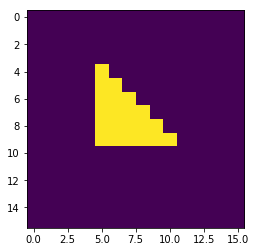

In [171]:
plt.imshow(class_zero_template)

In [172]:
# class_one_template[:, idx2]

In [173]:
# class_one_template = np.zeros((16,16))
# idx1 = (len(class_one_template)-2)//2
# idx2 = (len(class_one_template)-2)//2
# class_one_template[idx1] = 1
# class_one_template[idx1+1] = 1
# class_one_template[:, idx2]=1
# class_one_template[:, idx2+1]=1
# class_one_template

In [174]:
class_one_template = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

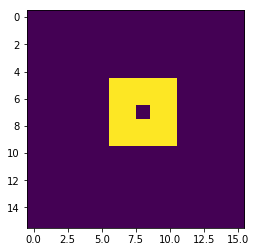

In [175]:
plt.imshow(class_one_template)

In [176]:
class_one_template.shape

(16, 16)

In [ ]:
class_one_template

#### Now we introduce some 'random noise', essentially switching a fixed number of pixels within our 16x16 map to 0

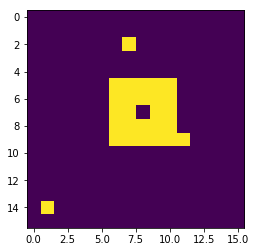

In [46]:
def generate_noise(input_img, num_of_pixels):
    idx1_arr = np.random.randint((input_img.shape[0]-1), size=num_of_pixels)
    idx2_arr = np.random.randint((input_img.shape[1]-1), size=num_of_pixels)
    out_img = np.copy(input_img)
    for i, j in zip(idx1_arr, idx2_arr):
        out_img[i][j] = 1
    return out_img

def image_generator(input_img, pixel_noise):
    while True:
        yield generate_noise(input_img, pixel_noise)

plt.imshow(generate_noise(class_one_template, 3))

# Generating data for the training and validation

In [47]:
class_zero_generator = image_generator(class_zero_template, 3)
class_one_generator = image_generator(class_one_template, 3)

# initialize those as None to make conditionals work in the loops
class_zero_train = None
class_zero_test = None
class_one_train = None
class_one_test = None

# roughly 80/20 split
train_size = 64
test_size = 13
for i in range(train_size):
    if class_zero_train is not None:
        class_zero_train = np.append(class_zero_train, np.expand_dims(next(class_zero_generator), axis=0), axis=0)
    else:
        class_zero_train = np.expand_dims(next(class_zero_generator), axis=0)
    if class_one_train is not None:
        class_one_train = np.append(class_one_train, np.expand_dims(next(class_one_generator), axis=0), axis=0)
    else: 
        class_one_train = np.expand_dims(next(class_one_generator), axis=0)

class_zero_labels = np.zeros(train_size)
class_one_labels = np.ones(train_size)

x_train = np.append(class_zero_train, class_one_train, axis=0)
y_train = np.append(class_zero_labels, class_one_labels)
    
for i in range(test_size):
    if class_zero_test is not None:
        class_zero_test = np.append(class_zero_test, np.expand_dims(next(class_zero_generator), axis=0), axis=0)
    else:
        class_zero_test = np.expand_dims(next(class_zero_generator), axis=0)
    if class_one_test is not None:
        class_one_test = np.append(class_one_test, np.expand_dims(next(class_one_generator), axis=0), axis=0)
    else:
        class_one_test = np.expand_dims(next(class_one_generator), axis=0)
    
class_zero_labels = np.zeros(test_size)
class_one_labels = np.ones(test_size)

x_test = np.append(class_zero_test, class_one_test, axis=0)
y_test = np.append(class_zero_labels, class_one_labels)

In [48]:
x_train.shape

(128, 16, 16)

In [49]:
y_train.shape

(128,)

In [50]:
x_test.shape

(26, 16, 16)

In [51]:
y_test.shape

(26,)

In [52]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# taken from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison  mrtw's answer

In [53]:
x_train, y_train = unison_shuffled_copies(x_train, y_train)
x_test, y_test = unison_shuffled_copies(x_test, y_test)

#### Let's try to visualize a few examples from the training set

In [54]:
x_train.shape

(128, 16, 16)

In [55]:
def show_something(dataset, labels, index):
    plt.imshow(x_train[index,:,:])
    print("label for this image is: {}".format(labels[index]))

label for this image is: 0.0


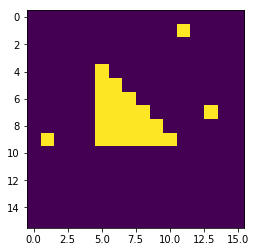

In [56]:
show_something(x_train, y_train, np.random.randint(len(y_train)-1))  # this shows a random image from the training dataset

#### Now we expand dimensions to stay consistent with NWHC, so we need to expand axis -1 (last one)

In [57]:
np.expand_dims(x_train, axis=-1).shape

(128, 16, 16, 1)

In [58]:
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

x_test = np.expand_dims(x_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Creating the model

In [676]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(16, 16, 1), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(128, (1, 1), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1,1), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [677]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 7, 7, 128)         8320      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                100368    
_________________________________________________________________
dense_55 (Dense)             (None, 1)               

In [678]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [679]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1), loss='binary_crossentropy', metrics=['accuracy'])

In [680]:
model.fit(x=x_train,
          y=y_train, 
          epochs=20, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 128 samples, validate on 26 samples
Epoch 1/20
128/128 [==============================] - 1s 5ms/sample - loss: 0.7046 - accuracy: 0.1406 - val_loss: 0.7051 - val_accuracy: 0.1154
Epoch 2/20
128/128 [==============================] - 0s 531us/sample - loss: 0.7022 - accuracy: 0.1797 - val_loss: 0.7028 - val_accuracy: 0.1538
Epoch 3/20
128/128 [==============================] - 0s 790us/sample - loss: 0.7000 - accuracy: 0.2344 - val_loss: 0.7006 - val_accuracy: 0.1923
Epoch 4/20
128/128 [==============================] - 0s 710us/sample - loss: 0.6978 - accuracy: 0.2969 - val_loss: 0.6985 - val_accuracy: 0.2692
Epoch 5/20
128/128 [==============================] - 0s 719us/sample - loss: 0.6958 - accuracy: 0.4062 - val_loss: 0.6965 - val_accuracy: 0.4231
Epoch 6/20
128/128 [==============================] - 0s 1ms/sample - loss: 0.6938 - accuracy: 0.5156 - val_loss: 0.6946 - val_accuracy: 0.4615
Epoch 7/20
128/128 [==============================] - 0s 885us/sample - loss: 0.691

In [70]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 24948), started -1 day, 23:01:40 ago. (Use '!kill 24948' to kill it.)

# Let's start tracing back the gradients

### First we need a sample image to make predictions on

In [681]:
im = next(image_generator(class_zero_template, 3))

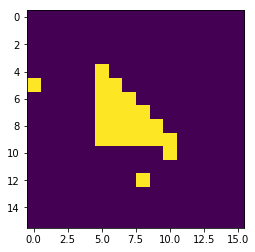

In [682]:
plt.imshow(im)

In [683]:
im.reshape(1, *im.shape, 1).shape

(1, 16, 16, 1)

In [684]:
model.predict(im.reshape(1, *im.shape, 1))  # prediction value

array([[0.49102256]], dtype=float32)

In [685]:
model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32))  # also a prediction value but using `call` instead of `predict`
# this returns a tf.Tensor

<tf.Tensor: id=144913, shape=(1, 1), dtype=float32, numpy=array([[0.49102256]], dtype=float32)>

#### We can use GradientTape to trace gradient values
Let's calculate the MSE for this particular predition

In [686]:
with tf.GradientTape() as tape:
    error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) - 0 # NOT model.predict(x) - y
    loss_value = tf.reduce_mean(tf.square(error))
gradients = tape.gradient(loss_value, model.variables)

`model.variables` is where kernels and biases live

In [687]:
print([i.name for i in model.variables])

['conv2d_51/kernel:0', 'conv2d_51/bias:0', 'conv2d_52/kernel:0', 'conv2d_52/bias:0', 'dense_54/kernel:0', 'dense_54/bias:0', 'dense_55/kernel:0', 'dense_55/bias:0']


We can create thus a list of all kernels and biases associated with any **convolutional layers** we have in our model and put it in a list (`A_k`).

In [688]:
def get_outputs_at_each_layer(model, input_image, layer_type):
    """
    make it robust to weird connections between layers
    """
    with tf.GradientTape() as tape:
        outputs = []
        out = model.get_layer(model.layers[0].name)(input_image)
        outputs.append(out)
        aux_input_dict = dict()
        for i in model.layers[1:]:
    #         out = model.get_layer(i.name)(out)
            outbound_nodes = model.get_layer(i.name).outbound_nodes
            inbound_nodes = model.get_layer(i.name).inbound_nodes
            for n in outbound_nodes:
                mapping = n.get_config()
    #             print(mapping['inbound_layers'])
                out = model.get_layer(mapping['inbound_layers'])(out)
                if layer_type in i.name:
                    outputs.append(out)
    #         print(i.name)
    gradients = tape.gradient(out, outputs)
    return outputs, gradients

In [689]:
A_k, dy_dA_k = get_outputs_at_each_layer(model, tf.cast(im.reshape(1, *im.shape, 1), tf.float32), 'conv')

In [690]:
# A_k = [i for i in model.variables if (('conv' in i.name) and ('kernel' in i.name))]
# print([i.name for i in A_k])

In [691]:
# with tf.GradientTape() as g:
#     error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) - 0 # NOT model.predict(x) - y
#     loss_value = tf.reduce_mean(tf.square(error))
# dy_dA_k = g.gradient(loss_value, A_k)

In [692]:
# with tf.GradientTape() as tape:
#     error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) - 0 # NOT model.predict(x) - y
#     loss_value = tf.reduce_mean(tf.square(error))
# gradients = tape.gradient(loss_value, model.variables)

In [693]:
# with tf.GradientTape() as g:
#     error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) # NOT model.predict(x) - y
#     feature_maps = get_outputs_at_each_layer(model, tf.cast(im.reshape(1, *im.shape, 1), tf.float32), 'conv')
    
# dy_dA_k = g.gradient(loss_value, A_k)

In [694]:
print(dy_dA_k[0].shape)

(1, 14, 14, 64)


# Grad-CAM

Having the derivative of loss function with respect to each conv kernel, we can now try to implement Grad-CAM from scratch

**The process is as follows**:

1. Compute gradient of scores for class `c` with respect to collected feature maps of a convolutional layer.
    
    $\large \frac{(\delta y^c)}{(\delta A^k)}$
    
2. Run Global Average Pooling on that gradient to obtain importance weights of each feature map.

    $\large \alpha^c_k = \frac{1}{Z} \Sigma_{i} \Sigma_{j} \frac{(\delta y^c)}{(\delta A^k)}$
    
3. Compute Grad-CAM $L^c$ function

    $\large L^c = ReLU(\Sigma_{k} \alpha^c_k A^k)$
    
    Here we use the ReLU to look only at pixels whose value actually contribute to the increase of $y^c$ scores
    
4. We upsample $L^c$ using bilinear interpolation method...

5. ... and finally perform pixel-wise multiplication with the guided backpropagation results.

In [695]:
gap = [tf.keras.layers.GlobalAveragePooling2D()(i) for i in dy_dA_k]
np.array(gap).shape  # thus each alpha_k is an element of the 'gap' list

(2, 1)

In [696]:
print(dy_dA_k[0].shape)
# print(dy_dA_k[1].shape)

(1, 14, 14, 64)


So we have two gradient tensors, first corresponding to the first layer which had `3x3` kernel size and the second corresponding to the `1x1` kernel. The last dimension is the actual number of feature maps within the tensor.

In [697]:
print(A_k[0].shape)
# print(A_k[1].shape)

(1, 14, 14, 64)


Shapes of the A_k elements are the same.

In [698]:
tf.math.multiply(dy_dA_k[0], A_k[0]).shape

TensorShape([1, 14, 14, 64])

In [699]:
L_c_0 = tf.keras.layers.ReLU()(tf.math.reduce_sum(tf.math.multiply(dy_dA_k[0], A_k[0]), axis=3))

In [700]:
L_c_0.shape

TensorShape([1, 14, 14])

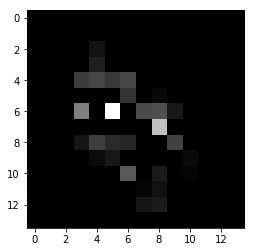

In [701]:
plt.imshow(L_c_0[0, :, :], cmap='gray')

In [702]:
# def unpack_maps(A_k, layer_idx):
#     new_shape = list(A_k[layer_idx].shape)
#     new_shape = [new_shape[-1]] + new_shape[:-1]
#     yield tf.reshape(A_k[layer_idx], new_shape).numpy()

In [703]:
# plt.imshow(test[1, 1, :, :], cmap='gray')

#### We pick one of three saliency maps and scale it down to original image size

In [704]:
test = L_c_0.numpy()

In [705]:
test.shape

(1, 14, 14)

In [706]:
def upsample_array(arr, final_shape):
    integer_div= []
    modulo = []
    out = np.copy(arr)
    assert len(final_shape) == len(arr.shape), "Output shape has to have same number of dims!"
    for i in range(len(arr.shape)):
        integer_div.append(final_shape[i]//arr.shape[i])
        modulo.append(final_shape[i]%arr.shape[i])
    if len(modulo) != 0:
        integer_div = [i+1 for i in integer_div]
    for idx, i in enumerate(integer_div):
        out = out.repeat(i, axis=idx)
    if out.shape != final_shape:
        start = [None for i in range(len(final_shape))]
        end = final_shape
        zipped = tuple(zip(start, final_shape))
        slices = tuple([slice(i[0], i[1]) for i in zipped])
        out = out[slices]
    return out

In [707]:
upsample_array(test[0, :, :], (16, 16)).shape

(16, 16)

In [708]:
test.shape

(1, 14, 14)

In [709]:
test_test = upsample_array(test[0, :, :], (16, 16))
test_test = Image.fromarray(test_test)
np.array(test_test).shape

(16, 16)

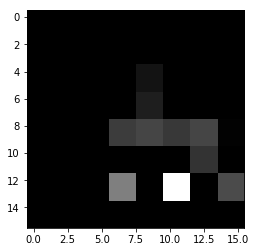

In [710]:
plt.imshow(test_test, cmap='gray')

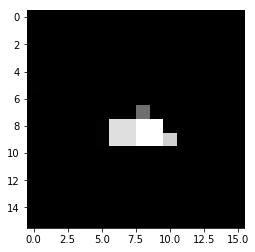

In [711]:
plt.imshow(im*test_test, cmap='gray')

#### Now we can make a heatmap of features that have been detected

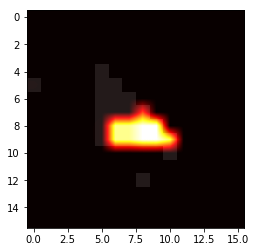

In [712]:
plt_im1 = plt.imshow(im, cmap=plt.cm.gray, interpolation='nearest')

plt_im2 = plt.imshow(test_test*im, cmap=plt.cm.hot, alpha=.9, interpolation='bilinear')

plt.show()